In [1]:
from proby import GameDirectedGraph, Probe
from proby.core import GameEnd
import matplotlib.pyplot as plt
import numpy as np
from typing import NamedTuple

In [2]:

from proby.tennis import init_match, play_match

In [14]:
class SimpleScore(NamedTuple):
    p1: int
    p2: int
    n_points: int

def play_simple_match(score: SimpleScore, p: Probe):
    if p.run():
        score = SimpleScore(score.p1 + 1, score.p2, score.n_points)
    else:
        score = SimpleScore(score.p1, score.p2 + 1, score.n_points)
    if score.p1 == score.n_points:
        return GameEnd.WIN
    elif score.p2 == score.n_points:
        return GameEnd.LOSE
    else:
        return score
simple_match_init = SimpleScore(0, 0, 87)

In [15]:
simple_match_graph = GameDirectedGraph.from_play_func(root=simple_match_init, play_func=play_simple_match)
tennis_match_graph = GameDirectedGraph.from_play_func(root=init_match, play_func=play_match)

def compute_derivative(graph: GameDirectedGraph, keys: tuple[str], deltap: float = 0.0001) -> float:
    vals = [graph.compute_probability(**{key: v for key in keys}) for v in (0.5, 0.5 + deltap)]
    return (vals[1] - vals[0]) / deltap
print(compute_derivative(simple_match_graph, ("p")))
print(compute_derivative(tennis_match_graph, ("p", "q")))

10.50969722920736
10.566637917128752


In [16]:
ps = np.arange(0.3,0.7,.001)
v1_n = np.array([simple_match_graph.compute_probability(p=p) for p in ps])
v2_n = np.array([tennis_match_graph.compute_probability(p=p, q=p) for p in ps])

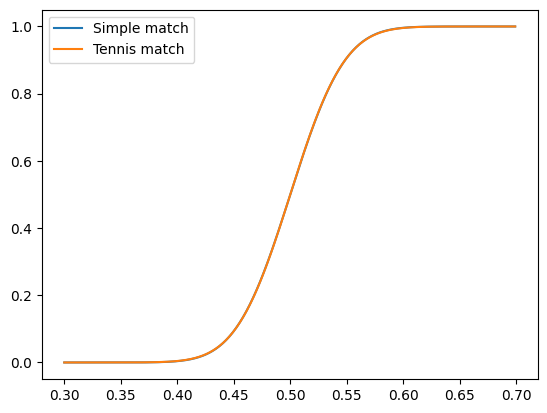

In [21]:
plt.plot(ps, v1_n, label="Simple match")
plt.plot(ps, v2_n, label="Tennis match")
plt.legend()

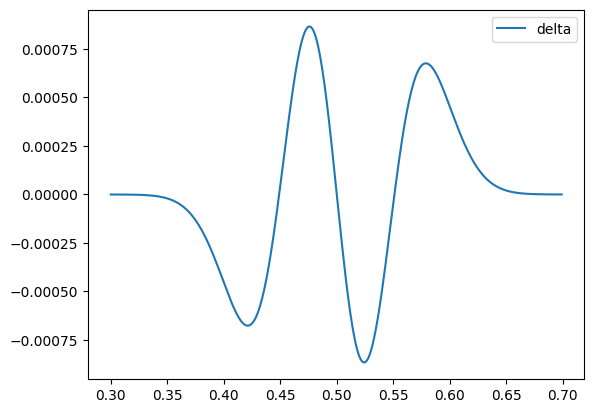

In [22]:
plt.plot(ps, v1_n - v2_n, label="delta")
plt.legend()

In [19]:
e1_n = np.array([simple_match_graph.compute_expected_value(p=p) for p in ps])
e2_n = np.array([tennis_match_graph.compute_expected_value(p=p, q=p) for p in ps])

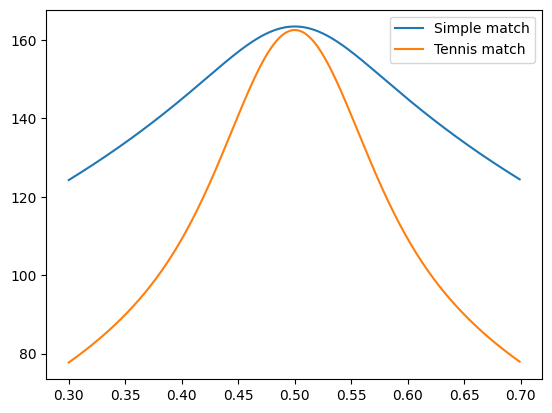

In [20]:
plt.plot(ps, e1_n, label="Simple match")
plt.plot(ps, e2_n, label="Tennis match")
plt.legend()
plt.legend()